In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.layers import \
    Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical
from src.util.load_dataset import load_dataset

# load and preprocess datasets
_, x_train, y_train = load_dataset('../dataset/sign_mnist_train.csv')
_, x_test, y_test = load_dataset('../dataset/sign_mnist_test.csv')

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

save_plots = True
text_color_white = False

In [14]:
# First experiment: How many convolution-subsampling pairs is best?

number_of_nets = 3
models = [0] * number_of_nets

for i in range(number_of_nets):
    models[i] = Sequential()
    models[i].add(Conv2D(filters=24, kernel_size=5, strides=(1, 1),
                        padding='same', activation='relu',
                        input_shape=(28, 28, 1)))
    models[i].add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                  data_format='channels_last'))
    if i > 0:
        models[i].add(Conv2D(filters=48, kernel_size=5, strides=(1, 1),
                            padding='same', activation='relu'))
        models[i].add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                  data_format='channels_last'))
    if i > 1:
        models[i].add(Conv2D(filters=64, kernel_size=5, strides=(1, 1),
                            padding='same', activation='relu'))
        models[i].add(MaxPool2D(pool_size=(2, 2), strides=None, padding='same',
                               data_format='channels_last'))
    models[i].add(Flatten())
    models[i].add(Dense(units=256, activation='relu'))
    models[i].add(Dense(units=24, activation='softmax'))
    models[i].compile(optimizer="adam", loss="categorical_crossentropy",
                     metrics=["accuracy"])

# create validation set
x_train2, x_val, y_train2, y_val = \
    train_test_split(x_train, y_train, test_size=0.333,
                     random_state=42, shuffle=False)
# train networks
histories = [0] * number_of_nets
names = ['1 Pair', '2 Pairs', '3 Pairs']
epochs = 10

for i in range(number_of_nets):
    histories[i] = models[i].fit(x_train2, y_train2, batch_size=80,
                                 epochs=epochs, validation_data=(x_val, y_val),
                                 callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f},"
          " Validation accuracy={3:.5f}"
        .format(names[i], epochs, max(histories[i].history['accuracy']),
                max(histories[i].history['val_accuracy'])))

CNN 1 Pair: Epochs=10, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 2 Pairs: Epochs=10, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 3 Pairs: Epochs=10, Train accuracy=1.00000, Validation accuracy=1.00000


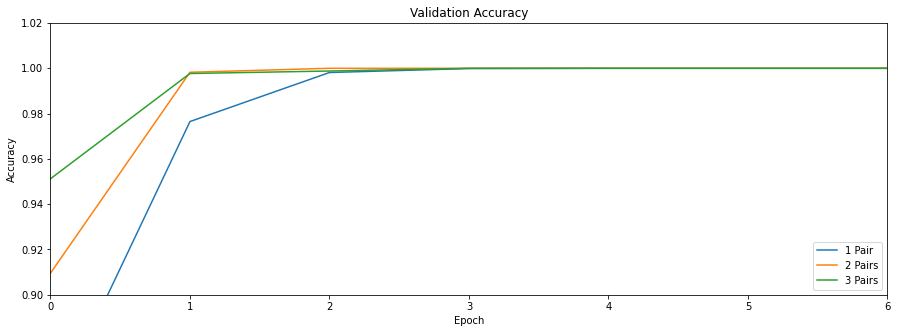

In [15]:
# PLOT ACCURACIES
f = plt.figure(figsize=(15, 5))
title_obj = plt.title('Validation Accuracy')

if text_color_white:
    params = {"ytick.color" : "w",
              "xtick.color" : "w",
              "axes.labelcolor" : "w",
              "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.setp(title_obj, color='w')

for i in range(number_of_nets):
    plt.plot(histories[i].history['val_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_xlim([0, 6])
axes.set_ylim([0.9, 1.02])

if save_plots:
    plt.savefig('../plots/experiment_1.svg',
                dpi=f.dpi,
                format='svg',
                transparent=True)
plt.show()

#RESULT: 2 pairs

In [16]:
# Second experiment: How many feature-maps?

nets = 6
model = [0] *nets
for j in range(6):
    model[j] = Sequential()
    model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(j*16+16,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu'))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ['8 maps', '16 maps', '24 maps', '32 maps', '48 maps', '64 maps']
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 8 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 16 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 24 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 32 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 48 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 64 maps: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000


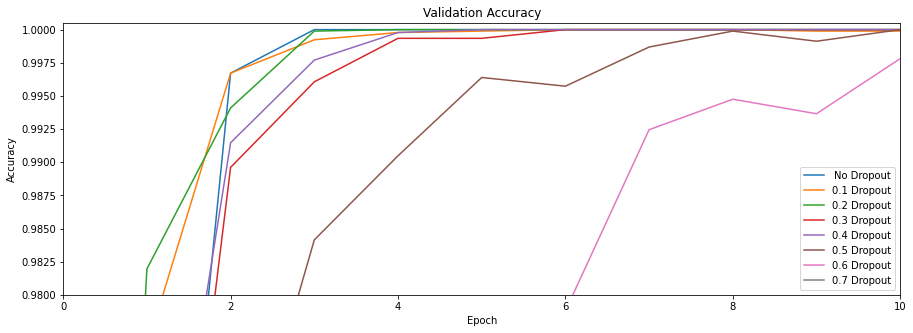

In [22]:
# PLOT ACCURACIES
f = plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('Validation Accuracy') #get the title property handler
if text_color_white:
    plt.setp(title_obj, color='w')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
for i in range(number_of_nets):
    plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_xlim([0, 10])
axes.set_ylim([0.9800, 1.0005])
if save_plots:
    plt.savefig('../plots/experiment_2.svg',
                dpi=f.dpi,
                format='svg',
                transparent=True)
plt.show()

# RESULT: 32 in first, 64 in second conv layer

In [18]:
# third experiment: how many units in the dense layer?

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())
    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu'))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["0 units","32 units","64 units","128 units","256 units",
         "512 units","1024 units","2048 units"]
epochs = 20
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN 0 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 32 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 64 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 128 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 256 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 512 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 1024 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 2048 units: Epochs=20, Train accuracy=1.00000, Validation accuracy=1.00000


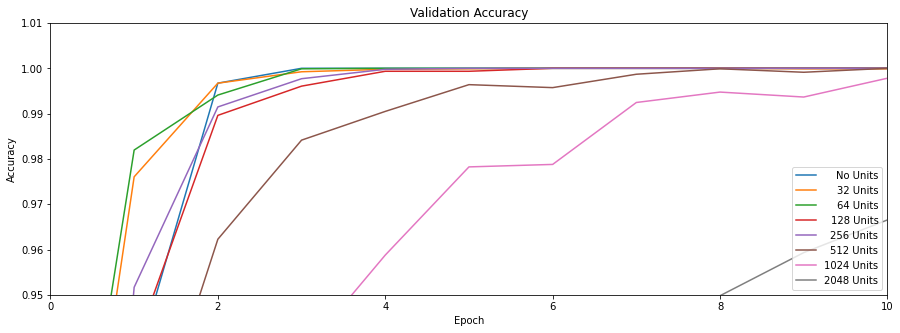

In [23]:
names = ["No Units","32 Units","64 Units","128 Units","256 Units",
         "512 Units","1024 Units","2048 Units"]
# PLOT ACCURACIES
f = plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('Validation Accuracy') #get the title property handler
if text_color_white:
    plt.setp(title_obj, color='w')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_ylim([0.95, 1.01])
axes.set_xlim([0, 10])
# axes.set_facecolor((.3,.3,.3))
if save_plots:
    plt.savefig('../plots/experiment_3.svg',
                dpi=f.dpi,
                format='svg',
                transparent=True)
plt.show()

# RESULT: 128 Neurons in the dense layer

In [20]:
# fourth experiment: how much dropout should we use

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] * nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(28,28,1)))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(128, activation='relu'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(24, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# CREATE VALIDATION SET
X_train2, X_val2, Y_train2, Y_val2 = \
    train_test_split(x_train, y_train, test_size = 0.333, random_state=42, shuffle=False)
# TRAIN NETWORKS
history = [0] * nets
names = ["No Dropout","0.1 Dropout", "0.2 Dropout", "0.3 Dropout",
         "0.4 Dropout", "0.5 Dropout","0.6 Dropout","0.7 Dropout"]
epochs = 30
for j in range(nets):
    history[j] = model[j].fit(X_train2,Y_train2, batch_size=80, epochs = epochs,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN No Dropout: Epochs=30, Train accuracy=1.00000, Validation accuracy=1.00000
CNN 0.1 Dropout: Epochs=30, Train accuracy=0.99984, Validation accuracy=1.00000
CNN 0.2 Dropout: Epochs=30, Train accuracy=0.99940, Validation accuracy=1.00000
CNN 0.3 Dropout: Epochs=30, Train accuracy=0.99716, Validation accuracy=1.00000
CNN 0.4 Dropout: Epochs=30, Train accuracy=0.99454, Validation accuracy=1.00000
CNN 0.5 Dropout: Epochs=30, Train accuracy=0.98007, Validation accuracy=1.00000
CNN 0.6 Dropout: Epochs=30, Train accuracy=0.93420, Validation accuracy=1.00000
CNN 0.7 Dropout: Epochs=30, Train accuracy=0.83530, Validation accuracy=0.99727


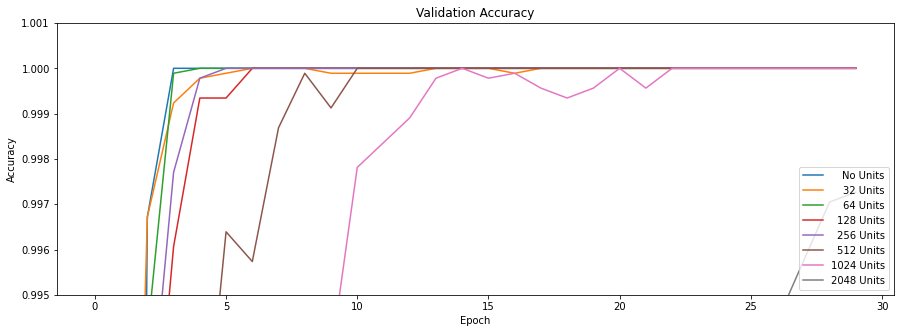

In [24]:
# PLOT ACCURACIES
plt.figure(figsize=(15, 5))
for i in range(nets):
    plt.plot(history[i].history['val_accuracy'])
title_obj = plt.title('Validation Accuracy') #get the title property handler
if text_color_white:
    plt.setp(title_obj, color='w')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
leg = axes.get_legend()
renderer = f.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for test in leg.get_texts():
    test.set_horizontalalignment('right')
    test.set_position((shift, 0))
axes.set_ylim([0.995, 1.001])
if save_plots:
    plt.savefig('../plots/experiment_4.svg',
                dpi=f.dpi,
                format='svg',
                transparent=True)
plt.show()

# RESULT 0.3 DROPOUT
